# pH DATA ANALYSIS. 

### Importing the necessary libraries to use

In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pylab as pylab

### We create two functions, set_col_index and sort_time_series to set column index and sort data based on date of data time series respectively

In [2]:
# set index column
class set_col_as_index(TransformerMixin):
    def __init__(self, col):
        self.col = col
    
    def transform (self, X, **transform_params):
        X.index = X.loc[:, self.col].apply(lambda x: pd.to_datetime(x))
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self

### Create index and transform the 'TimeStamp' column

In [3]:
#sort data based on the index
class sort_time_series(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.sort_index( )
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self
    


### Function to Process dataset

In [4]:
#Create index and transform the 'TimeStamp' column
def process_data(x):
    process_pipeline = make_pipeline(set_col_as_index('time'), sort_time_series())
    x = process_pipeline.fit_transform(x)
    del x['time']
    return x

### Function to load data from csv file, process and return the data

In [5]:
# get test data for water quality monitoring from this directory
def get_pH_data(data_path):
    return pd.read_csv(data_path)
data_path = './Data_Raw_Water.csv'
df = get_pH_data(data_path)
print('Number of Data samples ', len(df))
df.head()

Number of Data samples  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


### Display the general information on the dataset loaded

In [6]:
def display_info(df):
    print("Data Range \n")
    print("Start Date %s \n"%(df.head(1)['time']))
    print("End Date %s \n "%(df.tail (1)['time']))
    print("Num_values : %s "%(df.shape[0]))  
display_info(df)

Data Range 

Start Date 0    2020-11-04 11:00:31.822439+00:00
Name: time, dtype: object 

End Date 2657    2021-01-04 09:54:25.214766+00:00
Name: time, dtype: object 
 
Num_values : 2658 


### Plot the Original Dataset

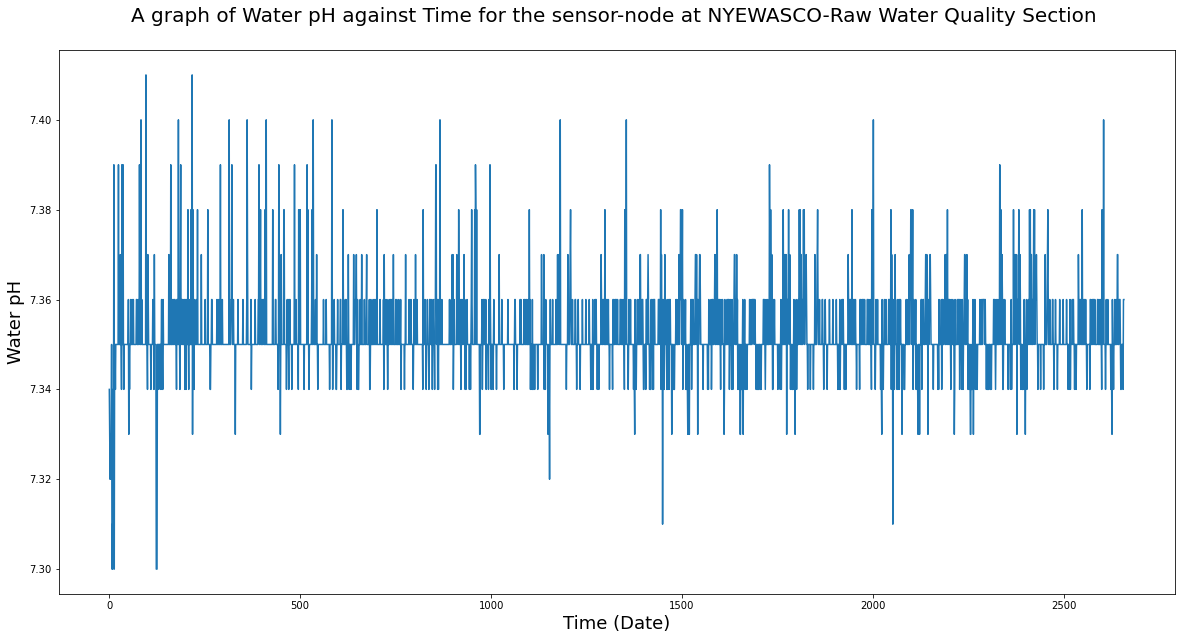

In [7]:
def plot_original_data(df, title):
    f1 = plt.figure(figsize =(20, 10))
    df['pH'].plot( )
    plt.xlabel("Time (Date)",size=18)
    plt.ylabel("Water pH",size=18)
    plt.title(title, size=20)
    plt.show( )
plot_original_data(df, "A graph of Water pH against Time for the sensor-node at NYEWASCO-Raw Water Quality Section \n")

### Prepare traning dataset

In [8]:
def prepare_traning_dataset(df):
    
    #lets get value of dataset
    X = df['pH'].values 
    
    # reshape the data to only one column
    X = X.reshape(-1, 1)
    return X

training_data = prepare_traning_dataset(df)

print('Items : ', len(training_data), '\n\n Head')
training_data[:5]

Items :  2658 

 Head


array([[7.34],
       [7.33],
       [7.32],
       [7.33],
       [7.32]])

### Preprocess training dataset 

In [9]:
# lets make the dates as index
df_pH = process_data(df)
df.head()

,time,turbidity,pH
time,,,
2020-11-04 11:00:31.822439+00:00,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
2020-11-04 11:01:22.124333+00:00,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2020-11-04 11:01:51.663062+00:00,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
2020-11-04 11:02:29.373718+00:00,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
2020-11-04 11:03:45.517010+00:00,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [10]:
df_pH = prepare_traning_dataset(df_pH)
df.head()

,time,turbidity,pH
time,,,
2020-11-04 11:00:31.822439+00:00,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
2020-11-04 11:01:22.124333+00:00,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2020-11-04 11:01:51.663062+00:00,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
2020-11-04 11:02:29.373718+00:00,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
2020-11-04 11:03:45.517010+00:00,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


### Get prediction result for the turbidity

In [11]:
%%time
clf = LocalOutlierFactor(n_neighbors=290, metric='euclidean')

def lof_prediction(clf, training_data_set, data_set):
    
    #fit clf with training data set
    y_pred = clf.fit_predict(training_data_set)
    
    #Get the prediction score
    y_pred = clf._decision_function(training_data_set)
    
    # combine training data and prediction result
    data_set['isinlier'] = y_pred
    
    #datascores less than -10  are outliers, we get them 
    anomalies = data_set.loc[data_set['isinlier']< -0.1]
    data_set
    return anomalies

df_turbidity_anomalies = lof_prediction(clf, df_pH, df)
anomalies_only = df_turbidity_anomalies[['pH', 'isinlier']]
anomalies_only

Wall time: 776 ms


,pH,isinlier
time,,
2020-11-04 11:00:31.822439+00:00,7.34,-3.082045e+06
2020-11-04 11:01:22.124333+00:00,7.33,-1.973840e+06
2020-11-04 11:01:51.663062+00:00,7.32,-2.778030e-01
2020-11-04 11:02:29.373718+00:00,7.33,-1.973840e+06
2020-11-04 11:03:45.517010+00:00,7.32,-2.778030e-01
...,...,...
2021-01-04 01:19:52.187717+00:00,7.37,-6.152675e+07
2021-01-04 01:50:08.249439+00:00,7.37,-6.152675e+07
2021-01-04 05:52:16.741753+00:00,7.34,-3.082045e+06


### Plotting the result of LOF anomaly detection

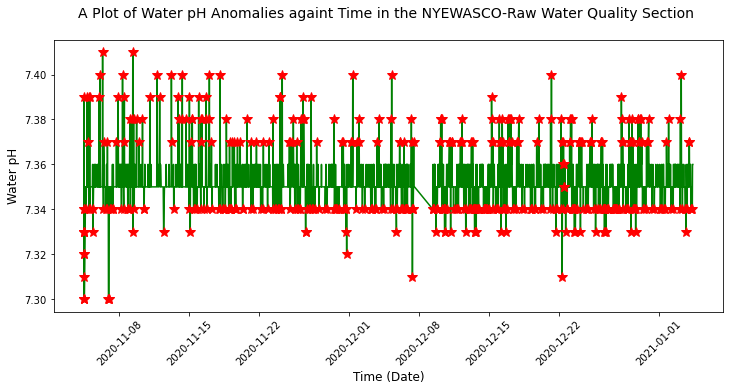

In [12]:
# lets plot the result of LOF anomaly detection
def plot_lof_result(dataset, anomalies, title):
    if 'isinlier' in dataset.columns:
        del dataset['isinlier']
        
    if 'isinlier' in anomalies.columns:
        del anomalies['isinlier']
        
    f2 = plt.figure(figsize =(12, 5))
    
    plt.plot(dataset['pH'], color='green')
    plt.plot(anomalies['pH'], "r*", markersize =10)
    plt.xlabel("Time (Date)", size=12)    
    plt.xticks(rotation=45);
    plt.ylabel("Water pH", size=12)
    plt.title(title, size=14)
    plt.show()
    
    
plot_lof_result(df, df_turbidity_anomalies , "A Plot of Water pH Anomalies againt Time in the NYEWASCO-Raw Water Quality Section \n ")
